In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq


file_path = r"C:\Users\flori\OneDrive - ETH Zurich\Semester 10\Master Thesis\Sim results\Heat release rates\iHRR_02.75_3"
df = pd.read_csv(file_path, sep=r'\s+')
print(df.iloc[:, 0].values)

[1.00000e-03 1.50000e-03 2.00000e-03 ... 4.99990e+01 4.99995e+01
 5.00000e+01]


[2.02783137e+01 1.27941491e+00 4.76896462e-01 ... 3.06775774e-04
 2.39781255e-04 3.95608870e-04]


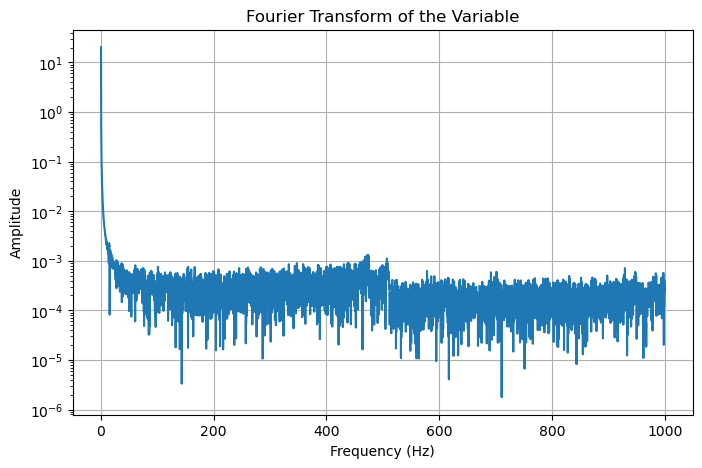

In [29]:
# Extract time and variable columns
time = df.iloc[:,0].values
HRR = df.iloc[:,1].values

#mask time
mask = time > (max(time) - 5)
time_cut = time[mask]
HRR_cut = HRR[mask]

# Compute time step (assuming evenly spaced time data)
dt = np.mean(np.diff(time_cut))  # Time step
fs = 1 / dt  # Sampling frequency

# Perform Fourier Transform
N = len(HRR_cut)  # Number of points
fft_values = fft(HRR_cut)  # Compute FFT
freqs = fftfreq(N, d=dt)  # Frequency components

# Keep only positive frequencies
mask = (freqs > 0)
positive_freqs = freqs[mask]
positive_fft_values = np.abs(fft_values[mask])

print(positive_fft_values)

plt.figure(figsize=(8, 5))
plt.semilogy(positive_freqs, positive_fft_values)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Transform of the Variable")
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Load the data
file_path = r"C:\Users\flori\OneDrive - ETH Zurich\Semester 10\Master Thesis\Sim results\Heat release rates\iHRR_02.75_3"
df = pd.read_csv(file_path, sep=r'\s+', names=["Time", "HRR"])

# Extract time and HRR
time = df["Time"].values
hrr = df["HRR"].values

# Compute Envelope Using Hilbert Transform
analytic_signal = hilbert(hrr)
envelope = np.abs(analytic_signal)  # This gives the oscillation envelope

# Compute a Moving Average of the Envelope
window_size = 50  # Adjust this depending on your data
moving_avg = np.convolve(envelope, np.ones(window_size)/window_size, mode='valid')

# Check for Increasing Trend (Instability)
time_moving_avg = time[:len(moving_avg)]  # Match time axis with moving average

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(time, hrr, label="HRR (Raw Data)", alpha=0.5)
plt.plot(time, envelope, label="Envelope (Hilbert Transform)", linestyle="dashed", color="red")
plt.plot(time_moving_avg, moving_avg, label="Smoothed Envelope", color="black", linewidth=2)
plt.xlabel("Time")
plt.ylabel("HRR Amplitude")
plt.title("HRR Stability Analysis")
plt.legend()
plt.grid()
plt.show()

# Check if the envelope shows exponential growth
from scipy.optimize import curve_fit

def exponential_func(t, a, b):
    return a * np.exp(b * t)

# Fit the moving average to an exponential curve
try:
    popt, _ = curve_fit(exponential_func, time_moving_avg, moving_avg, maxfev=5000)
    growth_rate = popt[1]

    if growth_rate > 0:
        print("⚠️ Instability detected! HRR amplitude is increasing exponentially.")
    else:
        print("✅ System appears stable. No exponential growth detected.")
except:
    print("Could not fit an exponential curve. Check the data.")
